In [ ]:
## parameters for experiment
N_BLOCK = 5
LR = 0.001

OUTPUT_DIR = '20251204-CorrectionNetworkTestv2.3'

RANDOM_SEED = 42

IN_CHANNEL = 1

AUGMENTED = False
AUGMENTATION  =  30

CROSS_VAL = False
N_SPLIT = 4

MINE_EPOCH = 25 # start mining after this epoch
MAX_MINE_TRAIN = 22
MAX_MINE_VAL = 11
MIN_ERROR_THRESHOLD = 150  

In [ ]:
## import libraries
from numpy.core.numeric import NaN
from MCtool.RFilter import gray
from genericpath import exists
from matplotlib import image
import math
import sys
import time

import cv2
from matplotlib import pyplot as plt
from tensorflow.python.keras.backend import dtype
from DeepLearning import LearnAndTest
from Rpkg.Rfund.InputFeature import InputFeature
import datetime
import os
import gc
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

import Filtering

import torch
from torch import nn


import DeepLearning
from tensorflow.keras.optimizers import Adam

from Rpkg.Rfund.InputFeature import InputFeature
from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

from MCtool import RFilter, resultEval
from DeepLearning import save_eval_result

import numpy as np
import cv2
import torch
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet4
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

#early stopping なし
from unet import UNet
from trainer import Trainer
from sklearn.model_selection import StratifiedKFold, train_test_split




2025-12-04 19:35:31.739472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 19:35:33.017327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
## random seed config
# Make sure there is no randomness in the output so that the output is reproduceable
import torch
import numpy as np
import random

# Set seed for Python random module
random.seed(RANDOM_SEED)

# Set seed for NumPy
np.random.seed(RANDOM_SEED)

# Set seed for PyTorch
torch.manual_seed(RANDOM_SEED)

# If you are using GPU
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Make the convolution operations deterministic
torch.backends.cudnn.deterministic = True

# Disable the CUDNN benchmark to ensure deterministic results
torch.backends.cudnn.benchmark = False


In [ ]:
## cuda and pytorch stats
# 自分の環境設定がうまくいったかどうかを確認しましょう、特にGPUの動作
# Prints the version of PyTorch installed
print('PyTorch Version installed: ' + torch.__version__)

# Prints the version of CUDA associated with the installed PyTorch version
print('CUDA version associated with PyTorch version: ' + torch.version.cuda)

# Prints the version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch
print('Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch' + str(torch.backends.cudnn.version()))

# Same as the line above
print('CUDA is available: ' + str(torch.cuda.is_available()))

# Returns the number of available CUDA-enabled GPUs
print('Number of GPUs compatible with CUDA:' + str(torch.cuda.device_count()))

# Returns the name of the GPU at index 0
print('Name of the GPU at index 0: '  + str(torch.cuda.get_device_name(0)))

# Returns the index of the current CUDA device being used
print('Current CUDA device index: '  + str(torch.cuda.current_device()))


PyTorch Version installed: 2.3.0+cu121
CUDA version associated with PyTorch version: 12.1
Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch8902
CUDA is available: True
Number of GPUs compatible with CUDA:1
Name of the GPU at index 0: NVIDIA GeForce RTX 2080 Ti
Current CUDA device index: 0


In [ ]:
## file_names_with_prefix
# ファイル名の先頭部分（prefix）により自動的にファイル名を抽出するアルゴリズム。
# 実際それぞれのファイル名は違うと思うので、必須ではない

""" 

Extracts filenames in directory if they start with the prefix input 


Args/Parameters:

    directory_path (string): The path of the dir (ex: /root/home/Documents/etc)
    
    prefix (string): Prefix of the file name (ex: 'Bo' is a prefix of 'Bone')

Returns:

    sorted_file_names (list of str): File names sorted in ascending order in the dir without extension ex: ['bone1', 'bone2', ...]

Raises:

    SomeError: ...

"""

def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names


In [ ]:
## paths config
import pathlib
from pathlib import Path

# ここで、folder名とかPathとか色々設定

# Setting the directory name, path and other settings

# Define the root directory where your project is located
# Defining a Path object for the project's root dir
root_dir = Path(pathlib.Path.cwd())

# result folder name
#date_str = '20241202-Conv1x1-' + str(OUTPUT_DIR)
date_str = OUTPUT_DIR

# Define the directories for different types of data
# Concatenating the root dir to the different dataset dirs
data_dir = str(root_dir / "img_1006t/original")
feature_dir = str(root_dir / "img_1006t/feature") 
labeled_dir = str(root_dir / "img_1006t/labeled")

augmented_labeled_dir = str(root_dir / "img_1006t/labelAug")
augmented_data_dir = str(root_dir / "img_1006t/originalAug")
augmented_feature_dir = str(root_dir / "img_1006t/featureAug")


# data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcOriginal")
# feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcFeature") 
# labeled_dir = str(root_dir / "img_1006t/labeled")

# augmented_labeled_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCLabel")
# augmented_data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCOriginal")
# augmented_feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCFeature")

# annealing_img_dir = str(root_dir / "img_1006/annealing_img") # 焼きなまし法時に使う
# annealing later, original for now
annealing_img_dir = str(root_dir / "img_1006/original")
result_dir = str(root_dir / "result" / date_str)
test_result_dir= str(root_dir / "result_test" / date_str)

# Making directories based on the path string result_dir and test_result_dir
Path(result_dir).mkdir(parents=True, exist_ok=True)
Path(test_result_dir).mkdir(parents=True, exist_ok=True)

# Prints the paths of the dirs
print('Root directory: ' + str(root_dir))
print('Data directory (original dir): ' + str(data_dir))
print('Feature img directory: ' + str(feature_dir))
print('Labeled img directory: ' + str(labeled_dir))
print('Annealing directory: ' + str(annealing_img_dir))
print('Result directory: ' + str(result_dir))
print('Test result directory: ' + str(test_result_dir))

# Defining variables filename list of path str starts with the prefix format
# In this case: N1 and N3 is training data and N2 is validation data and N4 is a test data
input_train = []
input_name_val = []
annealing_input_name = []
input_train = []
test_input_name = []


# for raw_input_img in INPUT:
#     input_train.extend(file_names_with_prefix(data_dir, raw_input_img))
# for raw_val_img in VALIDATION:
#     input_name_val.extend(file_names_with_prefix(data_dir, raw_val_img))
# for raw_anneal in ANNEALING:
#     annealing_input_name.extend(file_names_with_prefix(data_dir, raw_anneal))
# for raw_test in TEST:
#     test_input_name.extend(file_names_with_prefix(data_dir, raw_test))


####old version of assigning
# input_train = file_names_with_prefix(data_dir, INPUT)
# input_name_val = file_names_with_prefix(data_dir, VALIDATION)
# annealing_input_name = file_names_with_prefix(data_dir, ANNEALING)
# test_input_name = file_names_with_prefix(data_dir, TEST) 


# extra_dataset = file_names_with_prefix(data_dir,'N5-')
# input_train.extend(extra_dataset)

# Prints the each data image name
# print(input_train)
# print(input_name_val)
# print(annealing_input_name)
# print(test_input_name)
# print(extra_dataset)


# Defining a var to store each list length
len_train = len(input_train)
len_val = len(input_name_val)
len_test = len(test_input_name)
len_annealing = len(annealing_input_name)


# print(len(input_train))

# print(len(input_name_val))
# print(len(test_input_name))
# print(len(annealing_input_name))


Root directory: /home/eric/Documents/cervicalResearchIIP
Data directory (original dir): /home/eric/Documents/cervicalResearchIIP/img_1006t/original
Feature img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/feature
Labeled img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled
Annealing directory: /home/eric/Documents/cervicalResearchIIP/img_1006/original
Result directory: /home/eric/Documents/cervicalResearchIIP/result/20251204-CorrectionNetworkTestv2.3
Test result directory: /home/eric/Documents/cervicalResearchIIP/result_test/20251204-CorrectionNetworkTestv2.3


In [ ]:
## filters
# 特徴画像の特徴一覧をリストとして取得#
#inputfeature_list = list(map(str, InputFeature))
inputfeature_list = ['CLA_']

print(inputfeature_list)
feature_num = len(inputfeature_list)


print(feature_num)

['CLA_']
1


In [ ]:
## createweightimage read by images
# takes too much memory cuz it loads all images into np array at once


## 重み計算なし
def CreateWeightImage(input_number, augmentation=False):
    print("Creating image arrays...")
    label_dataset = []
    arrDataset = []
    for i in input_number:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/" , f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                    
        label_dataset.append(input_originallabel)

    print("Number of label images:", len(label_dataset))


    
    for i in input_number:
        # changed this part from 100 to 256

        dataset_img =  np.zeros((256, 256, feature_num), dtype=np.float32)
            
            
        for m in range(feature_num):
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/" , str(i), f"{inputfeature_list[m]}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{inputfeature_list[m]}.png")
            input_featureimg = cv2.imread(feature_img_path, cv2.IMREAD_GRAYSCALE)
            dataset_img[:, :, m] = input_featureimg

        arrDataset.append(dataset_img)

    arrDataset = np.array(arrDataset)
    print("Completed creating image arrays:")
    print("Dataset shape ", arrDataset.shape)
    print("Label image shape ", np.shape(label_dataset))
    print()

    return arrDataset, label_dataset


In [ ]:
## createweightimagenew read paths only
def CreateWeightImageNew(input_numbers, augmentation=False):
    print("Creating image paths...")
    label_paths = []
    feature_paths = []

    for i in input_numbers:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/", f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        label_paths.append(label_path)

        feature_img_paths = []
        for feature_name in inputfeature_list:
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/", str(i), f"{feature_name}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{feature_name}.png")
            feature_img_paths.append(feature_img_path)

        feature_paths.append(feature_img_paths)

    print(f"Processed {len(label_paths)} label paths and {len(feature_paths)} feature paths.")
    return feature_paths, label_paths


In [ ]:
## minor irrelevant function
def print_model_shapes(model, input_tensor):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        print("-----------------------")

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    print("Model Architecture:")
    print(model)

    # Pass a dummy input tensor through the model to trigger the forward hooks
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()


In [ ]:
## preprocess and postprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # Change from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # Linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # Typecasting to float32
    #print("in pre")
    #print(np.unique(img))
    return img

# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim = 1)  # Perform argmax to generate 1 channel
    #img = img * 255.0 commented as the labels are from 0 to 11 in my case
    img = img.cpu().numpy().astype(np.uint8)  # Send to CPU and transform to numpy.ndarray
    # If batch_size > 1, you may need to loop through each batch and save them separately
    # If batch_size == 1, you can remove the batch dimension to save a single image

    # used for checking the unique label values whether if it is 0 to 11 or 0 to 255 scale
    #print("in post")
    #print(np.unique(img))


    img = np.squeeze(img)  # Remove batch dim and channel dim -> [H, W]
    # img = re_normalize(img)  # Scale it to the range [0-255]

    # If your image has multiple channels (C>1), like an RGB image, before saving with cv2.imwrite
    # you need to ensure the channel order is [B, G, R] instead of the common [R, G, B]
    # If C == 1, you can further reduce dimensions -> [H, W]
    if img.shape[0] == 3:  # [C, H, W]
        img = np.transpose(img, (1, 2, 0))  # [H, W, C]
        img = img[:, :, ::-1]  # Convert RGB to BGR
    elif img.shape[0] == 1:  # [C, H, W]
        img = np.squeeze(img, 0)  # [H, W]
    return img


In [ ]:
def record_results(training_losses, validation_losses, lr_rates, learning_curve, model, fold, input_dataset_val, input_name_val, type_number, device, model_n = "unet1"):
    
    #logging to csv
    assert len(training_losses) == len(validation_losses) == len(lr_rates), \
        "Lengths of training, validation losses, and learning rates must match."

    # Create dataframe
    df = pd.DataFrame({
        "Epoch": list(range(1, len(training_losses) + 1)),
        "Training_Loss": training_losses,
        "Validation_Loss": validation_losses,
        "Learning_Rate": lr_rates
    })

    # Save to CSV
    df.to_csv(test_result_dir + f"/{model_n}_fold{fold}_log.csv", index = False)
    
    learning_curve.savefig(test_result_dir + f"/{model_n}_fold{fold}_learningcurve.png")
    
    print("***************************")

    
    
    
    #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    model_dir = os.path.join("model", date_str)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = f"{model_n}_fold_{fold}.pt"
    model_path = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"modelname:{model_name}を保存しました")
    #torch.cuda.empty_cache()
    

    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    
    

    # images = annealing_input_dataset
    images = input_dataset_val

    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict the segmentation maps 
    # output = [predict(img, model, preprocess, postprocess, device) for img in images]


    # for i in range(len(input_name_val)):
    #     if(type_number == 0):
    #         cv2.imwrite(os.path.join(result_dir, f'{model_n}_{input_name_val[i]}.png'), output[i])
    #     elif(type_number == 1):
    #         cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
    #     elif(type_number == 2):
    #         cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])

In [ ]:
## learn_ea function training logic
# earlystoppingあり
# numpy形式のまま入力する用改良
# 学習を行い予測結果画像を出力するとこまで
from customdatasets import SegmentationDataSet0
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet5
from torch.utils.data import DataLoader

def Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, type_number, fold=0, next_model = False, model_n = "unet1", inChannels = 1):
    print("*************************Training*************************")
    # 引数を追加して保存先を指定するよう改良
    # try_number:何回目の焼きなましかどうか。モデルの保存に使用


    if next_model is False:
        
        dataset_train2 = SegmentationDataSet0(
            inputs=input_dataset,        # train_preds
            targets=label_dataset,       # train_targets
            transform=None
        )

        dataset_val = SegmentationDataSet0(
            inputs=input_dataset_val,    # val_preds
            targets=label_dataset_val,   # val_targets
            transform=None
    )
    else:

        dataset_train2 = SegmentationDataSet0(
            inputs=input_dataset,        # original images
            targets=label_dataset,       # GT masks
            transform=transforms_training
        )

        dataset_val = SegmentationDataSet0(
            inputs=input_dataset_val,    # original validation images
            targets=label_dataset_val,   # GT masks
            transform=transforms_val
        )

    

    dataloader_training2 = DataLoader(dataset=dataset_train2,
                                        batch_size = 2,
                                        shuffle=True)
                                        #num_workers=4,
                                        #pin_memory=True)
        #もとはシャッフルtrue
    
        


    batch = next(iter(dataloader_training2))
  
    x, y = batch
    print("x.shape = ", x.shape)
    print("x.min(), x.max() = ", x.min(), x.max())
    print("y.shape = ", y.shape)
    print("torch.unique(y) = ", torch.unique(y))


    
    # # dataset training
    # dataset_val = SegmentationDataSet0(inputs=input_dataset_val,
    #                                     targets=label_dataset_val,
    #                                     transform=transforms_val)
    # if next_model==False:
    #     dataset_val = SegmentationDataSet0(inputs=input_dataset_val,
    #                                     targets=label_dataset_val,
    #                                     transform=None)
        
    #書き換え箇所
    dataloader_val = DataLoader(dataset=dataset_val,
                                     batch_size = 2,
                                     shuffle=False)
                                     #num_workers=4, # for faster training loads next batch while training
                                     #pin_memory=True)  # for faster training, keeps data in pinned memory
    
    
    
    ###earlystopping あり

    from unet import UNet
    from trainer2 import Trainer2 
    from torch import nn #import torch 
    from pytorchtools import EarlyStopping
    from torch.nn import BCEWithLogitsLoss
    from customLoss import DiceCELoss
    from customLoss import DiceLoss
    from customLoss import ExponentialLogCE_DiceLoss
    from customLoss import EnsembleInspiredLoss
    from customLoss import ConfusionPenaltyLoss
    from customLoss import CombinedLoss

    #device
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else: 
        torch.device('cpu')
        print("Before creating the UNet model: GPU was not available and CPU will be used instead")

    # custom logging the parameters of the UNet
    inChannels = inChannels
    outChannels = 11
    nBlocks = N_BLOCK
    startFilters = 32

    from customLog import custom_logger
    
    #custom_logger("/log/customLog.log", inChannels, outChannels, nBlocks, startFilters)

    #model
    model = UNet(in_channels = inChannels,
                 out_channels = outChannels,
                 n_blocks = nBlocks, 
                 start_filters=32,
                 activation='relu',
                 normalization='instance',
                 conv_mode='same',
                 dim=2,
                 ).to(device)
    
    # printing parameter name of the model could be done for criterion too
    # for name, param in model.named_parameters():
    #     print(name, param.device, param.requires_grad)
        
        


    # Assuming input_tensor is a sample input tensor with the correct shape (e.g., torch.randn(1, 3, 100, 100))
    input_tensor = torch.randn(1, 45, 100, 100).to(device)  # Adjust the shape as needed
    # print_model_shapes(model, input_tensor)

    from customLoss import BoundaryDiceLoss

    from customLoss import BoundaryIOU
    from customLoss import BoundaryDiceLoss
    from customLoss import FocalLoss
    from customLoss import CombinedLossV2
    from customLoss import CombinedLoss
    from customLoss import DiceLoss
    from customLoss import EnsembleInspiredLoss
    from customLoss import HausdorffLoss
    from customLoss import JointCELossHausdorff

    
    criterion = torch.nn.CrossEntropyLoss()
    

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #trainer
    trainer = Trainer2(model=model, 
                       device=device, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       training_DataLoader=dataloader_training2,
                       #validation_DataLoader=None, 
                       validation_DataLoader=dataloader_val, 
                       lr_scheduler=None, 
                       epochs=200, ##😺😺😺😺 epoch=0, 
                       notebook=True,
                       mine_epoch = MINE_EPOCH,
                       max_mine_train = MAX_MINE_TRAIN,
                       max_mine_val = MAX_MINE_VAL,
                       min_error_threshold = MIN_ERROR_THRESHOLD
                       )
    print("=======start training======")
    
    # start training
    #for combined
    training_losses, validation_losses, lr_rates, learning_curve, train_preds, train_targets, val_preds, val_targets = trainer.run_trainer()
    trainer.plot_mined_samples(n=10, split='train')
    trainer.plot_mined_samples(n=10, split='val')
    

    def safe_cat(tensors):
        if isinstance(tensors, torch.Tensor):
            return tensors  # already a tensor
        if len(tensors) == 0:
            raise RuntimeError("No predictions collected.")
        return torch.cat(tensors, dim=0)

    train_preds = safe_cat(train_preds)  # [N, C, H, W]
    train_targets = safe_cat(train_targets)  # [N, H, W]

    val_preds = safe_cat(val_preds)
    val_targets = safe_cat(val_targets)



    
    record_results(training_losses, validation_losses, lr_rates, learning_curve, model, fold, input_dataset_val, input_name_val, type_number, device, model_n)
    
    # Force garbage collection
    gc.collect()

    # Clear CUDA memory
    torch.cuda.empty_cache()

    # Optionally reset max memory tracking
    torch.cuda.reset_peak_memory_stats()
    
    if next_model == False:
        return
    
    inChannels = 11
    
    return Learn_EA(train_preds, train_targets, val_preds, val_targets, type_number, fold, next_model = False, model_n="unet2", inChannels=11)
    
    # #logging to csv
    # assert len(training_losses) == len(validation_losses) == len(lr_rates), \
    #     "Lengths of training, validation losses, and learning rates must match."

    # # Create dataframe
    # df = pd.DataFrame({
    #     "Epoch": list(range(1, len(training_losses) + 1)),
    #     "Training_Loss": training_losses,
    #     "Validation_Loss": validation_losses,
    #     "Learning_Rate": lr_rates
    # })

    # # Save to CSV
    # df.to_csv(test_result_dir + f"/fold{fold}_log.csv", index = False)
    
    # learning_curve.savefig(test_result_dir + f"/fold{fold}_learningcurve.png")
    
    # print("***************************")

    
    
    
    # #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    # model_dir = os.path.join("model", date_str)
    # if not os.path.exists(model_dir):
    #     os.makedirs(model_dir)
    # model_name = f"model_fold_{fold}.pt"
    # model_path = os.path.join(model_dir, model_name)
    # torch.save(model.state_dict(), model_path)
    # print(f"modelname:{model_name}を保存しました")
    # #torch.cuda.empty_cache()
    

    # model_weights = torch.load(model_path)
    # model.load_state_dict(model_weights)
    
    

    # # images = annealing_input_dataset
    # images = input_dataset_val

    # from inference import predict
    # from transformations import normalize_01, re_normalize
    # # predict the segmentation maps 
    # output = [predict(img, model, preprocess, postprocess, device) for img in images]


    # for i in range(len(input_name_val)):
    #     if(type_number == 0):
    #         cv2.imwrite(os.path.join(result_dir, f'{input_name_val[i]}.png'), output[i])
    #     elif(type_number == 1):
    #         cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
    #     elif(type_number == 2):
    #         cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])



In [ ]:
## dice calculation
import statistics
# Dicecの計算
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice


In [ ]:

## mConv_predict test function
import statistics
from inference import predict
from denseCRF import noiseReduction
# device
def mConv_predict(test_input_name, fold=0):
    print("*************************************Test*************************************")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---------- Load Models ----------
    model_dir = os.path.join("model", date_str)
    model1_path = os.path.join(model_dir, f"unet1_fold_{fold}.pt")
    model2_path = os.path.join(model_dir, f"unet2_fold_{fold}.pt")

    model1 = UNet(in_channels=IN_CHANNEL,  # check the parameters
            out_channels=11,
            n_blocks=N_BLOCK,
            start_filters=32,
            activation='relu',
            normalization='instance', #use instance when "batch" size is less than 10? batch
            conv_mode='same',
            dim=2).to(device)
    
    model2 = UNet(in_channels=11,  # check the parameters
            out_channels=11,
            n_blocks=N_BLOCK,
            start_filters=32,
            activation='relu',
            normalization='instance', #use instance when "batch" size is less than 10? batch
            conv_mode='same',
            dim=2).to(device)


    model1.load_state_dict(torch.load(model1_path))
    model2.load_state_dict(torch.load(model2_path))

    model1.eval()
    model2.eval()

    # ---------- Load Test ----------
    test_input_dataset, _ = CreateWeightImage(test_input_name)

    output_stage1 = []
    output_stage2 = []

    # ---------- Stage-1 + Stage-2 ----------
    with torch.no_grad():
        for img in test_input_dataset:
            result1, prob1, pred1 = predict(img, model1, preprocess, postprocess, device)

            # Save stage-1 output (mask form)
            output_stage1.append(pred1)

            # prob1 shape: [1,11,H,W] → correct Stage-2 input
            prob1 = prob1.to(device)  
            out2 = model2(prob1)
            pred2 = torch.argmax(out2, 1).squeeze().cpu().numpy()
            output_stage2.append(pred2)

    # ---------- Save results ----------
    fold_dir = os.path.join(test_result_dir, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)

    unet1_dir = os.path.join(fold_dir, "unet1")
    unet2_dir = os.path.join(fold_dir, "unet2")
    os.makedirs(unet1_dir, exist_ok=True)
    os.makedirs(unet2_dir, exist_ok=True)

    for i, name in enumerate(test_input_name):
        cv2.imwrite(os.path.join(unet1_dir, f"{name}.png"), output_stage1[i])
        cv2.imwrite(os.path.join(unet2_dir, f"{name}.png"), output_stage2[i])

    # ---------- Dice + CRF ----------
    Dice1 = cal_DiceMulitple(unet1_dir, test_input_name)
    Dice2 = cal_DiceMulitple(unet2_dir, test_input_name)
    pd.DataFrame(Dice1).T.to_csv(f"{test_result_dir}/unet1Dice.csv", mode='a', header=False)
    pd.DataFrame(Dice2).T.to_csv(f"{test_result_dir}/unet2Dice.csv", mode='a', header=False)

    postCRF1 = noiseReduction(output_stage1, test_input_name, labeled_dir, unet1_dir, 0.8)
    postCRF2 = noiseReduction(output_stage2, test_input_name, labeled_dir, unet2_dir, 0.8)

    DiceCRF1 = cal_DiceMulitple(unet1_dir + "/crf", test_input_name)
    DiceCRF2 = cal_DiceMulitple(unet2_dir + "/crf", test_input_name)
    pd.DataFrame(DiceCRF1).T.to_csv(f"{test_result_dir}/unet1CRFDice.csv", mode='a', header=False)
    pd.DataFrame(DiceCRF2).T.to_csv(f"{test_result_dir}/unet2CRFDice.csv", mode='a', header=False)
    
    df1 = pd.DataFrame([Dice1])
    df2 = pd.DataFrame([Dice2])

    # Get last column value
    last_val1 = df1.iloc[0, -1]
    last_val2 = df2.iloc[0, -1]

    return last_val1, last_val2


In [ ]:
import optuna
import os
from optuna.visualization import plot_optimization_history, plot_param_importances
import json
import traceback

STUDY_NAME = "unet_stage2"
DB_PATH = "sqlite:///unet_optuna.db"
BEST_JSON_PATH = "best_trial.json"
LOG_PATH = "training_log.txt"

def log(msg: str):
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(msg + "\n")



['N1-1' 'N1-2' 'N1-3' 'N1-4' 'N1-5' 'N1-6' 'N1-7' 'N1-8' 'N1-9' 'N1-10'
 'N2-1' 'N2-2' 'N2-3' 'N2-4' 'N2-5' 'N2-6' 'N2-7' 'N2-8' 'N2-9' 'N2-10'
 'N3-1' 'N3-2' 'N3-3' 'N3-4' 'N3-5' 'N3-6' 'N3-7' 'N3-8' 'N3-9' 'N3-10'
 'N4-1' 'N4-2' 'N4-3' 'N4-4' 'N4-5' 'N4-6' 'N4-7' 'N4-8' 'N4-9' 'N5-1'
 'N5-2' 'N5-3' 'N5-4' 'N5-5' 'N5-6']
['N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N2' 'N2' 'N2' 'N2'
 'N2' 'N2' 'N2' 'N2' 'N2' 'N2' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3'
 'N3' 'N3' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N5' 'N5' 'N5'
 'N5' 'N5' 'N5']
Cross validation: True
Fold: 1 out of 4
Augmentation: True
Augmentation amount: 30
Training: Total of 22 cases.
['N4-9' 'N3-1' 'N2-8' 'N3-10' 'N5-5' 'N2-3' 'N4-3' 'N1-7' 'N1-10' 'N1-1'
 'N3-8' 'N2-6' 'N5-4' 'N2-4' 'N4-4' 'N1-9' 'N1-3' 'N3-5' 'N5-3' 'N3-6'
 'N4-8' 'N2-7']
Validation: Total of 11 cases.
['N4-5' 'N5-2' 'N2-10' 'N1-8' 'N3-4' 'N4-2' 'N3-7' 'N4-7' 'N2-5' 'N1-5'
 'N2-9']
Test: Total of 12 cases.
['N1-2' 'N1-4' 'N1-6' 'N2-1' 'N2-2' '

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 1.4628418853788665
val_losses 1.079732341116125
lr 0.0001
Validation loss decreased (inf --> 1.079732).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.7889504055182139
val_losses 0.7375477064739574
lr 0.0001017999999999998
Validation loss decreased (1.079732 --> 0.737548).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.49776688452922935
val_losses 0.5773849906343402
lr 0.00010360000000000001
Validation loss decreased (0.737548 --> 0.577385).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.3329651187315132
val_losses 0.4649876314582247
lr 0.00010539999999999981
Validation loss decreased (0.577385 --> 0.464988).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.22999465768084382
val_losses 0.40623901242559607
lr 0.00010720000000000002
Validation loss decreased (0.464988 --> 0.406239).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.16970086547009872
val_losses 0.3779757078849908
lr 0.00010899999999999982
Validation loss decreased (0.406239 --> 0.377976).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.13138485824068388
val_losses 0.33925237520174545
lr 0.00011080000000000001
Validation loss decreased (0.377976 --> 0.339252).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.10420180297259128
val_losses 0.3398641552888986
lr 0.00011259999999999981
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.10909717453248573
val_losses 0.29214953816298284
lr 0.00011440000000000002
Validation loss decreased (0.339252 --> 0.292150).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.07390130864399852
val_losses 0.29168475477984457
lr 0.00011619999999999982
Validation loss decreased (0.292150 --> 0.291685).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0596587726112568
val_losses 0.28706648981932437
lr 0.00011800000000000002
Validation loss decreased (0.291685 --> 0.287066).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05048821744593707
val_losses 0.2994243185628544
lr 0.00011979999999999982
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04316542687063867
val_losses 0.3043269707397981
lr 0.00012160000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03789710583108844
val_losses 0.28085738375331415
lr 0.00012339999999999983
Validation loss decreased (0.287066 --> 0.280857).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.033906776294337984
val_losses 0.3062935056108417
lr 0.00012520000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.030571170659227806
val_losses 0.3105582184863813
lr 0.00012699999999999983
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02757108679436373
val_losses 0.2933438443776333
lr 0.00012880000000000004
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.025032404714235755
val_losses 0.33343361421968
lr 0.00013059999999999984
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.023080770914075954
val_losses 0.31968023018403485
lr 0.00013240000000000002
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.021023559982352183
val_losses 0.29853425161405045
lr 0.00013419999999999985
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.019991007018269915
val_losses 0.3137920715140574
lr 0.00013600000000000003
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01852144067542571
val_losses 0.29969676150517033
lr 0.00013779999999999983
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01709065603826082
val_losses 0.3492161756212061
lr 0.00013960000000000003
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.016211722376333042
val_losses 0.32665288389632197
lr 0.00014139999999999983
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 1
Train preds for stage 2: 2
Train preds for stage 2: 3
Train preds for stage 2: 4
Train preds for stage 2: 5
Train preds for stage 2: 6
Train preds for stage 2: 7
Train preds for stage 2: 8
Train preds for stage 2: 9
Train preds for stage 2: 10
Train preds for stage 2: 11
Train preds for stage 2: 12
Train preds for stage 2: 13
Train preds for stage 2: 14
Train preds for stage 2: 15
Train preds for stage 2: 16
Train preds for stage 2: 17
Train preds for stage 2: 18
Train preds for stage 2: 19
Train preds for stage 2: 20
Train preds for stage 2: 21
Train preds for stage 2: 22
Train preds for stage 2: 23
Train preds for stage 2: 24
Train preds for stage 2: 25
Train preds for stage 2: 26
Train preds for stage 2: 27
Train preds for stage 2: 28
Train preds for stage 2: 29
Train preds for stage 2: 30
Train preds for stage 2: 31
Train preds for stage 2: 32
Train preds for stage 2: 33
Train preds for stage 2: 34
Train preds for stage 2: 35
Train preds for stage 2: 36
T

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
Val preds for stage 2: 561
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 562
Train preds for stage 2: 563
Train preds for stage 2: 564
Train preds for stage 2: 565
Train preds for stage 2: 566
Train preds for stage 2: 567
Train preds for stage 2: 568
Train preds for stage 2: 569
Train preds for stage 2: 570
Train preds for stage 2: 571
Train preds for stage 2: 572
Train preds for stage 2: 573
Train preds for stage 2: 574
Train preds for stage 2: 575
Train preds for stage 2: 576
Train preds for stage 2: 577
Train preds for stage 2: 578
Train preds for stage 2: 579
Train preds for stage 2: 580
Train preds for stage 2: 581
Train preds for stage 2: 582
Train preds for stage 2: 583
Train preds for stage 2: 584
Train preds for stage 2: 585
Train preds for stage 2: 586
Train preds for stage 2: 587
Train preds for stage 2: 588
Train preds for stage 2: 589
Train preds for stage 2: 590
Train preds for stage 2: 591
Train preds for stage 2: 592
Train preds for stage 2: 593
Train preds for stage 2: 594
Train preds for stage 2: 595
Train preds fo

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.013775379972701724
val_losses 0.3400613669193152
lr 0.00014680000000000004
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.013072887483532681
val_losses 0.34573752564011195
lr 0.00014859999999999984
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.012480101802132347
val_losses 0.3613257791959878
lr 0.00015040000000000005
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.012081353225265488
val_losses 0.3888373384873072
lr 0.00015219999999999985
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.011692299944997736
val_losses 0.37633207986752193
lr 0.00015400000000000006
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01138176621982094
val_losses 0.3676715584866928
lr 0.00015579999999999986
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.011068626608925335
val_losses 0.33467918661507695
lr 0.00015760000000000006
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.010733224564429485
val_losses 0.4123766531546911
lr 0.00015939999999999986
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05296508932881283
val_losses 0.21689479357816957
lr 0.00016120000000000007
Validation loss decreased (0.280857 --> 0.216895).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.018544010549896593
val_losses 0.24952941523356872
lr 0.00016299999999999984
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.014504218411942323
val_losses 0.2748403598413323
lr 0.00016480000000000005
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01249831079533606
val_losses 0.27588824720093696
lr 0.00016659999999999988
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.011197071113256794
val_losses 0.3329880676937826
lr 0.00016840000000000008
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.010236021804369309
val_losses 0.3438803200920423
lr 0.00017019999999999985
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009603809019212019
val_losses 0.34449408849080404
lr 0.00017200000000000006
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009330272556028583
val_losses 0.3696650456750032
lr 0.0001737999999999999
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009209900116547941
val_losses 0.37344730997627434
lr 0.00017560000000000007
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00920650765553794
val_losses 0.3783745082941922
lr 0.00017739999999999987
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009002637054601853
val_losses 0.3641396658890175
lr 0.00017920000000000007
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008641948754137213
val_losses 0.365902025049383
lr 0.00018099999999999987
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008676253836319753
val_losses 0.3416849791100531
lr 0.00018280000000000008
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008716288324671261
val_losses 0.3434888668132551
lr 0.00018459999999999988
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008419076375889055
val_losses 0.3598748004797733
lr 0.00018640000000000009
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00841674228537489
val_losses 0.38492509424686433
lr 0.00018819999999999989
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008262102413132336
val_losses 0.3830892677559997
lr 0.00019000000000000006
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008370577065612781
val_losses 0.37704332570234933
lr 0.0001917999999999999
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.021314997086301447
val_losses 0.30706090638131806
lr 0.0001936000000000001
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.030510450786713397
val_losses 0.17550181739709594
lr 0.00019539999999999987
Validation loss decreased (0.216895 --> 0.175502).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.014033981127608003
val_losses 0.22517274731036388
lr 0.00019720000000000008
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.010967564139740937
val_losses 0.2418856493902929
lr 0.0001989999999999999
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00943662852302871
val_losses 0.27427733888228734
lr 0.0002008000000000001
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008461533975081913
val_losses 0.2941005035331755
lr 0.00020259999999999988
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007699777383470174
val_losses 0.3125631098042835
lr 0.0002044000000000001
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0073026630745241135
val_losses 0.33123370386434325
lr 0.00020619999999999992
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007163467935540459
val_losses 0.31387876150282945
lr 0.0002080000000000001
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007451691292226314
val_losses 0.3252725753368753
lr 0.0002097999999999999
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007408536533175996
val_losses 0.33998841191783097
lr 0.0002116000000000001
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007127482030597148
val_losses 0.3342646510312052
lr 0.0002133999999999999
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00692893511220587
val_losses 0.3307782143354416
lr 0.0002152000000000001
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006799537783037081
val_losses 0.35391073800397643
lr 0.0002169999999999999
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0066956699515382445
val_losses 0.35645251802422784
lr 0.00021880000000000011
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006862835442139344
val_losses 0.33788655946652096
lr 0.00022059999999999991
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006628842962284883
val_losses 0.34403828811464887
lr 0.0002224000000000001
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.047503655477229394
val_losses 0.1539426360166434
lr 0.00022419999999999992
Validation loss decreased (0.175502 --> 0.153943).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.020606415436574908
val_losses 0.1537347714557792
lr 0.00022600000000000013
Validation loss decreased (0.153943 --> 0.153735).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.015620323761620305
val_losses 0.177411930985523
lr 0.0002277999999999999
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.012883836143847667
val_losses 0.20061054347139418
lr 0.0002296000000000001
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.011322094776639433
val_losses 0.21118098723165918
lr 0.00023139999999999993
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0102178119405201
val_losses 0.23250814802718886
lr 0.00023320000000000014
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009353347805639107
val_losses 0.24545050990400893
lr 0.0002349999999999999
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008622212916838401
val_losses 0.2689759996804324
lr 0.00023680000000000012
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008192453677342696
val_losses 0.2761252120137215
lr 0.00023859999999999994
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00791157772623454
val_losses 0.278811828521165
lr 0.00024040000000000015
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007647893795122703
val_losses 0.2841229684876673
lr 0.00024219999999999992
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007349918486381119
val_losses 0.2902904166416688
lr 0.00024400000000000013
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007067169500232646
val_losses 0.2986547324693564
lr 0.00024579999999999996
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0068568247469198524
val_losses 0.3130513561494423
lr 0.0002476000000000001
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006774126432102286
val_losses 0.32401888478886
lr 0.00024939999999999994
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006517305999824947
val_losses 0.31941294873302634
lr 0.00025120000000000014
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006355261217068994
val_losses 0.3208924588380438
lr 0.0002529999999999999
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006331753170569286
val_losses 0.3496795396010081
lr 0.0002548000000000001
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0064351625881637585
val_losses 0.3272017443270394
lr 0.00025659999999999995
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006332685458332751
val_losses 0.3401663240609747
lr 0.00025840000000000016
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006213116381938259
val_losses 0.337598714593685
lr 0.00026019999999999993
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006002099027462078
val_losses 0.34512929234540823
lr 0.00026200000000000013
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02331961350176822
val_losses 0.20241985542304589
lr 0.00026379999999999996
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.017132639179401325
val_losses 0.23889791879690056
lr 0.00026560000000000017
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.010667941568306449
val_losses 0.25946043540130964
lr 0.00026739999999999994
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00846395295423766
val_losses 0.28836893665068075
lr 0.00026920000000000015
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0070889184265538596
val_losses 0.30234612569664465
lr 0.000271
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006179606145473592
val_losses 0.32235070299921614
lr 0.0002728000000000002
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005607878322938852
val_losses 0.3292593399232084
lr 0.00027459999999999995
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00538452467105041
val_losses 0.3465168865341129
lr 0.00027640000000000016
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005274039373563772
val_losses 0.3312256326278051
lr 0.00027819999999999993
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005244173976649163
val_losses 0.33803750484278705
lr 0.00028000000000000014
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005315210178466231
val_losses 0.33617768346360233
lr 0.00028179999999999997
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00522976228967309
val_losses 0.3472632955421101
lr 0.00028360000000000017
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005255788998593661
val_losses 0.3412811000238765
lr 0.00028539999999999994
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005027296252294698
val_losses 0.34650089000210615
lr 0.00028720000000000015
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005095085076225752
val_losses 0.3564777890841166
lr 0.000289
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004880779542057126
val_losses 0.3425275919112292
lr 0.0002908000000000002
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005027506158292068
val_losses 0.3833654289895838
lr 0.00029259999999999996
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00479146326595748
val_losses 0.3668250852462017
lr 0.00029440000000000016
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004646242482615917
val_losses 0.36285747939890084
lr 0.0002962
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004518953564746136
val_losses 0.3921400025035396
lr 0.0002980000000000002
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004503362440983906
val_losses 0.39032808921553874
lr 0.00029979999999999997
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004377246418064742
val_losses 0.35691950727592814
lr 0.0003016000000000002
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004217588798509854
val_losses 0.37980491338354166
lr 0.0003034
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004160812373668181
val_losses 0.35893156672969007
lr 0.00030520000000000015
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004076875410409588
val_losses 0.3688411095828721
lr 0.000307
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003985955656477899
val_losses 0.3442176045793476
lr 0.0003088000000000002
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0038306720872324975
val_losses 0.3924620285178676
lr 0.00031059999999999996
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003910941479614738
val_losses 0.383983964992292
lr 0.0003123999999999998
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003960915044599184
val_losses 0.3673511522285866
lr 0.0003142
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003641324507241899
val_losses 0.38745853169397876
lr 0.0003160000000000002
EarlyStopping counter: 50 out of 50
early stopping epoch: 120
Saved mined train samples figure to: ./log/mined_train_samples_epoch121.png
Saved mined val samples figure to: ./log/mined_val_samples_epoch121.png
***************************
modelname:unet1_fold_1.ptを保存しました
*************************Training*************************
x.shape =  torch.Size([2, 11, 256, 256])
x.min(), x.max() =  tensor(0.) tensor(1.0000)
y.shape =  torch.Size([2, 256, 256])
torch.unique(y) =  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
in constructor inchannel: 11
Input channel count9
=======start training======


Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 1.4696489456928137
val_losses 1.1498683084141124
lr 0.0001
Validation loss decreased (inf --> 1.149868).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.6989292745337342
val_losses 0.7527884934887742
lr 0.0001017999999999998
Validation loss decreased (1.149868 --> 0.752788).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.4125393927548871
val_losses 0.6061830908963175
lr 0.00010360000000000001
Validation loss decreased (0.752788 --> 0.606183).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.2825291327454827
val_losses 0.5283945294943723
lr 0.00010539999999999981
Validation loss decreased (0.606183 --> 0.528395).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.2060495200933832
val_losses 0.48000834421678024
lr 0.00010720000000000002
Validation loss decreased (0.528395 --> 0.480008).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.15606983279188474
val_losses 0.4461595333886869
lr 0.00010899999999999982
Validation loss decreased (0.480008 --> 0.446160).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.12207073982466352
val_losses 0.4406745018381061
lr 0.00011080000000000001
Validation loss decreased (0.446160 --> 0.440675).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.09822857908227227
val_losses 0.4164520139947082
lr 0.00011259999999999981
Validation loss decreased (0.440675 --> 0.416452).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.08062182925641537
val_losses 0.4136696224862879
lr 0.00011440000000000002
Validation loss decreased (0.416452 --> 0.413670).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.06708124417698745
val_losses 0.41273779209816097
lr 0.00011619999999999982
Validation loss decreased (0.413670 --> 0.412738).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05644808175663153
val_losses 0.40802388696959524
lr 0.00011800000000000002
Validation loss decreased (0.412738 --> 0.408024).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04774694355825583
val_losses 0.409678808667443
lr 0.00011979999999999982
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04087720046553648
val_losses 0.41463364443995737
lr 0.00012160000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03529822010772698
val_losses 0.41685322405713976
lr 0.00012339999999999983
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0307335316909082
val_losses 0.4397720195127256
lr 0.00012520000000000003
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.026881416982999354
val_losses 0.4479752338293827
lr 0.00012699999999999983
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.023858197902639707
val_losses 0.4532844590418266
lr 0.00012880000000000004
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0211372932927175
val_losses 0.455430468916893
lr 0.00013059999999999984
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01895858097369924
val_losses 0.46318212855945934
lr 0.00013240000000000002
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.016983119610019706
val_losses 0.47959346608682113
lr 0.00013419999999999985
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.015430573568764058
val_losses 0.490437512235208
lr 0.00013600000000000003
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.014035569069286187
val_losses 0.5011103163162868
lr 0.00013779999999999983
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.012816721883912882
val_losses 0.498195698315447
lr 0.00013960000000000003
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.011745234748179262
val_losses 0.5160199940204621
lr 0.00014139999999999983
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 1
Train preds for stage 2: 2
Train preds for stage 2: 3
Train preds for stage 2: 4
Train preds for stage 2: 5
Train preds for stage 2: 6
Train preds for stage 2: 7
Train preds for stage 2: 8
Train preds for stage 2: 9
Train preds for stage 2: 10
Train preds for stage 2: 11
Train preds for stage 2: 12
Train preds for stage 2: 13
Train preds for stage 2: 14
Train preds for stage 2: 15
Train preds for stage 2: 16
Train preds for stage 2: 17
Train preds for stage 2: 18
Train preds for stage 2: 19
Train preds for stage 2: 20
Train preds for stage 2: 21
Train preds for stage 2: 22
Train preds for stage 2: 23
Train preds for stage 2: 24
Train preds for stage 2: 25
Train preds for stage 2: 26
Train preds for stage 2: 27
Train preds for stage 2: 28
Train preds for stage 2: 29
Train preds for stage 2: 30
Train preds for stage 2: 31
Train preds for stage 2: 32
Train preds for stage 2: 33
Train preds for stage 2: 34
Train preds for stage 2: 35
Train preds for stage 2: 36
T

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
Val preds for stage 2: 182
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 183
Train preds for stage 2: 184
Train preds for stage 2: 185
Train preds for stage 2: 186
Train preds for stage 2: 187
Train preds for stage 2: 188
Train preds for stage 2: 189
Train preds for stage 2: 190
Train preds for stage 2: 191
Train preds for stage 2: 192
Train preds for stage 2: 193
Train preds for stage 2: 194
Train preds for stage 2: 195
Train preds for stage 2: 196
Train preds for stage 2: 197
Train preds for stage 2: 198
Train preds for stage 2: 199
Train preds for stage 2: 200
Train preds for stage 2: 201
Train preds for stage 2: 202
Train preds for stage 2: 203
Train preds for stage 2: 204
Train preds for stage 2: 205
Train preds for stage 2: 206
Train preds for stage 2: 207
Train preds for stage 2: 208
Train preds for stage 2: 209
Train preds for stage 2: 210
Train preds for stage 2: 211
Train preds for stage 2: 212
Train preds for stage 2: 213
Train preds for stage 2: 214
Train preds for stage 2: 215
Train preds for stage 2: 216
Train preds fo

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009928300877976599
val_losses 0.540691001758431
lr 0.00014499999999999984
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 336
Train preds for stage 2: 337
Train preds for stage 2: 338
Train preds for stage 2: 339
Train preds for stage 2: 340
Train preds for stage 2: 341
Train preds for stage 2: 342
Train preds for stage 2: 343
Train preds for stage 2: 344
Train preds for stage 2: 345
Train preds for stage 2: 346
Train preds for stage 2: 347
Train preds for stage 2: 348
Train preds for stage 2: 349
Train preds for stage 2: 350
Train preds for stage 2: 351
Train preds for stage 2: 352
Train preds for stage 2: 353
Train preds for stage 2: 354
Train preds for stage 2: 355
Train preds for stage 2: 356
Train preds for stage 2: 357
Train preds for stage 2: 358
Train preds for stage 2: 359
Train preds for stage 2: 360
Train preds for stage 2: 361
Train preds for stage 2: 362
Train preds for stage 2: 363
Train preds for stage 2: 364
Train preds for stage 2: 365
Train preds for stage 2: 366
Train preds for stage 2: 367
Train preds for stage 2: 368
Train preds for stage 2: 369
Train preds fo

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009186783259395849
val_losses 0.5546085755030314
lr 0.00014680000000000004
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 448
Train preds for stage 2: 449
Train preds for stage 2: 450
Train preds for stage 2: 451
Train preds for stage 2: 452
Train preds for stage 2: 453
Train preds for stage 2: 454
Train preds for stage 2: 455
Train preds for stage 2: 456
Train preds for stage 2: 457
Train preds for stage 2: 458
Train preds for stage 2: 459
Train preds for stage 2: 460
Train preds for stage 2: 461
Train preds for stage 2: 462
Train preds for stage 2: 463
Train preds for stage 2: 464
Train preds for stage 2: 465
Train preds for stage 2: 466
Train preds for stage 2: 467
Train preds for stage 2: 468
Train preds for stage 2: 469
Train preds for stage 2: 470
Train preds for stage 2: 471
Train preds for stage 2: 472
Train preds for stage 2: 473
Train preds for stage 2: 474
Train preds for stage 2: 475
Train preds for stage 2: 476
Train preds for stage 2: 477
Train preds for stage 2: 478
Train preds for stage 2: 479
Train preds for stage 2: 480
Train preds for stage 2: 481
Train preds fo

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008684849218380723
val_losses 0.5496563412023313
lr 0.00014859999999999984
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 550
Train preds for stage 2: 551
Train preds for stage 2: 552
Train preds for stage 2: 553
Train preds for stage 2: 554
Train preds for stage 2: 555
Train preds for stage 2: 556
Train preds for stage 2: 557
Train preds for stage 2: 558
Train preds for stage 2: 559
Train preds for stage 2: 560
Train preds for stage 2: 561
Train preds for stage 2: 562
Train preds for stage 2: 563
Train preds for stage 2: 564
Train preds for stage 2: 565
Train preds for stage 2: 566
Train preds for stage 2: 567
Train preds for stage 2: 568
Train preds for stage 2: 569
Train preds for stage 2: 570
Train preds for stage 2: 571
Train preds for stage 2: 572
Train preds for stage 2: 573
Train preds for stage 2: 574
Train preds for stage 2: 575
Train preds for stage 2: 576
Train preds for stage 2: 577
Train preds for stage 2: 578
Train preds for stage 2: 579
Train preds for stage 2: 580
Train preds for stage 2: 581
Train preds for stage 2: 582
Train preds for stage 2: 583
Train preds fo

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008022308369364703
val_losses 0.5502359110297579
lr 0.00015040000000000005
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 618
Train preds for stage 2: 619
Train preds for stage 2: 620
Train preds for stage 2: 621
Train preds for stage 2: 622
Train preds for stage 2: 623
Train preds for stage 2: 624
Train preds for stage 2: 625
Train preds for stage 2: 626
Train preds for stage 2: 627
Train preds for stage 2: 628
Train preds for stage 2: 629
Train preds for stage 2: 630
Train preds for stage 2: 631
Train preds for stage 2: 632
Train preds for stage 2: 633
Train preds for stage 2: 634
Train preds for stage 2: 635
Train preds for stage 2: 636
Train preds for stage 2: 637
Train preds for stage 2: 638
Train preds for stage 2: 639
Train preds for stage 2: 640
Train preds for stage 2: 641
Train preds for stage 2: 642
Train preds for stage 2: 643
Train preds for stage 2: 644
Train preds for stage 2: 645
Train preds for stage 2: 646
Train preds for stage 2: 647
Train preds for stage 2: 648
Train preds for stage 2: 649
Train preds for stage 2: 650
Train preds for stage 2: 651
Train preds fo

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007635717153210531
val_losses 0.5752621542323719
lr 0.00015219999999999985
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007061818872832439
val_losses 0.5867958053494945
lr 0.00015400000000000006
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006694547390339501
val_losses 0.5842950186946175
lr 0.00015579999999999986
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006212041198247762
val_losses 0.6027209746115135
lr 0.00015760000000000006
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005973051144092372
val_losses 0.615625451189099
lr 0.00015939999999999986
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005772654949264093
val_losses 0.6156858003500736
lr 0.00016120000000000007
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005592304080809382
val_losses 0.6261017225908511
lr 0.00016299999999999984
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005203121438424921
val_losses 0.6341075213569584
lr 0.00016480000000000005
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004846486199477857
val_losses 0.6378634657823679
lr 0.00016659999999999988
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004752810962611076
val_losses 0.649852731552991
lr 0.00016840000000000008
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004742484791627662
val_losses 0.6532584709651542
lr 0.00017019999999999985
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004486938309150212
val_losses 0.6580220407608783
lr 0.00017200000000000006
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004274888788208817
val_losses 0.671597896380858
lr 0.0001737999999999999
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004135134739265071
val_losses 0.6753216084205743
lr 0.00017560000000000007
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004033774783072824
val_losses 0.6848715110258623
lr 0.00017739999999999987
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00382398783624398
val_losses 0.6834846958969578
lr 0.00017920000000000007
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0038670315428382973
val_losses 0.6949450292370536
lr 0.00018099999999999987
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003683577760856486
val_losses 0.6973289448203462
lr 0.00018280000000000008
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0037292549167900826
val_losses 0.7013856689135234
lr 0.00018459999999999988
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0035291130266462763
val_losses 0.7106715402819893
lr 0.00018640000000000009
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003320871524258771
val_losses 0.7025592236807852
lr 0.00018819999999999989
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003313388852543677
val_losses 0.7228091758308989
lr 0.00019000000000000006
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00318630912736284
val_losses 0.7218973566185344
lr 0.0001917999999999999
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003182447291769539
val_losses 0.7203881225802682
lr 0.0001936000000000001
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0030842026053560954
val_losses 0.7154025115750052
lr 0.00019539999999999987
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003086246176848583
val_losses 0.7381880053968141
lr 0.00019720000000000008
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0030525786735145655
val_losses 0.7293263543735851
lr 0.0001989999999999999
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002863052137421839
val_losses 0.7470953247763894
lr 0.0002008000000000001
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0027389132206074216
val_losses 0.7316594414638751
lr 0.00020259999999999988
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0027544745663886493
val_losses 0.7608968965934985
lr 0.0002044000000000001
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002743697517452705
val_losses 0.7570461578441389
lr 0.00020619999999999992
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0026634284866635096
val_losses 0.7484974732904723
lr 0.0002080000000000001
EarlyStopping counter: 50 out of 50
early stopping epoch: 60
Saved mined train samples figure to: ./log/mined_train_samples_epoch61.png
Saved mined val samples figure to: ./log/mined_val_samples_epoch61.png
***************************
modelname:unet2_fold_1.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count9
in constructor inchannel: 11
Input channel count9
Creating image arrays...
Number of label images: 12
Completed creating image arrays:
Dataset shape  (12, 256, 256, 1)
Label image shape  (12, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251204-CorrectionNetworkTestv2.3/fold1/unet1/N1-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-2.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251204-CorrectionNetworkTestv2.3/fold

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 1.7185976458318306
val_losses 1.4223483562469483
lr 0.0001
Validation loss decreased (inf --> 1.422348).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.8963252837007696
val_losses 1.0204259372419782
lr 0.0001017999999999998
Validation loss decreased (1.422348 --> 1.020426).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.47079738396586795
val_losses 0.8407309050361316
lr 0.00010360000000000001
Validation loss decreased (1.020426 --> 0.840731).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.3124027895204949
val_losses 0.6875982377264235
lr 0.00010539999999999981
Validation loss decreased (0.840731 --> 0.687598).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.22389135031086027
val_losses 0.736879226896498
lr 0.00010720000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.16872684594356652
val_losses 0.7166454281244014
lr 0.00010899999999999982
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.13219194080341945
val_losses 0.7547473946379291
lr 0.00011080000000000001
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10613939656001149
val_losses 0.7938904590904713
lr 0.00011259999999999981
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08677415145617542
val_losses 0.7383543310066064
lr 0.00011440000000000002
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07237272000674046
val_losses 0.7844664379954338
lr 0.00011619999999999982
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06150284160041448
val_losses 0.822360061109066
lr 0.00011800000000000002
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05302786389083573
val_losses 0.8391731905440489
lr 0.00011979999999999982
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.045218602161515846
val_losses 0.8591732401814726
lr 0.00012160000000000003
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.040384143444173265
val_losses 0.801697930196921
lr 0.00012339999999999983
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03571975612166253
val_losses 0.8443028820885552
lr 0.00012520000000000003
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.13048097271133552
val_losses 0.41021785802311367
lr 0.00012699999999999983
Validation loss decreased (0.687598 --> 0.410218).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06116763186274153
val_losses 0.4276624526000685
lr 0.00012880000000000004
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0413745451944344
val_losses 0.470653834235337
lr 0.00013059999999999984
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03297092848542062
val_losses 0.501311795744631
lr 0.00013240000000000002
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.028311100280420345
val_losses 0.5149169953333007
lr 0.00013419999999999985
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02518114238187219
val_losses 0.523597998999887
lr 0.00013600000000000003
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.023023948282229176
val_losses 0.5695478957560327
lr 0.00013779999999999983
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.020992592208538996
val_losses 0.6022208995289273
lr 0.00013960000000000003
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.019308357127010824
val_losses 0.5735568379362425
lr 0.00014139999999999983
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 1
Train preds for stage 2: 2
Train preds for stage 2: 3
Train preds for stage 2: 4
Train preds for stage 2: 5
Train preds for stage 2: 6
Train preds for stage 2: 7
Train preds for stage 2: 8
Train preds for stage 2: 9
Train preds for stage 2: 10
Train preds for stage 2: 11
Train preds for stage 2: 12
Train preds for stage 2: 13
Train preds for stage 2: 14
Train preds for stage 2: 15
Train preds for stage 2: 16
Train preds for stage 2: 17
Train preds for stage 2: 18
Train preds for stage 2: 19
Train preds for stage 2: 20
Train preds for stage 2: 21
Train preds for stage 2: 22
Train preds for stage 2: 23
Train preds for stage 2: 24
Train preds for stage 2: 25
Train preds for stage 2: 26
Train preds for stage 2: 27
Train preds for stage 2: 28
Train preds for stage 2: 29
Train preds for stage 2: 30
Train preds for stage 2: 31
Train preds for stage 2: 32
Train preds for stage 2: 33
Train preds for stage 2: 34
Train preds for stage 2: 35
Train preds for stage 2: 36
T

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
Val preds for stage 2: 633
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 634
Train preds for stage 2: 635
Train preds for stage 2: 636
Train preds for stage 2: 637
Train preds for stage 2: 638
Train preds for stage 2: 639
Train preds for stage 2: 640
Train preds for stage 2: 641
Train preds for stage 2: 642
Train preds for stage 2: 643
Train preds for stage 2: 644
Train preds for stage 2: 645
Train preds for stage 2: 646
Train preds for stage 2: 647
Train preds for stage 2: 648
Train preds for stage 2: 649
Train preds for stage 2: 650
Train preds for stage 2: 651
Train preds for stage 2: 652
Train preds for stage 2: 653
Train preds for stage 2: 654
Train preds for stage 2: 655
Train preds for stage 2: 656
Train preds for stage 2: 657
Train preds for stage 2: 658
Train preds for stage 2: 659
Train preds for stage 2: 660


Validation:   0%|          | 0/180 [00:00<?, ?it/s]

Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.016924795135855673
val_losses 0.6509216327634123
lr 0.00014680000000000004
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.017478734051639383
val_losses 0.6163654185831546
lr 0.00014859999999999984
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01537352968289545
val_losses 0.6832619783778985
lr 0.00015040000000000005
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.014673066920967716
val_losses 0.6721556346449588
lr 0.00015219999999999985
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01445143259497303
val_losses 0.697705619285504
lr 0.00015400000000000006
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.013995221133033435
val_losses 0.7268812612526947
lr 0.00015579999999999986
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01402961936863986
val_losses 0.7289957448840141
lr 0.00015760000000000006
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.014278762592849407
val_losses 0.6986447811954551
lr 0.00015939999999999986
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01265418612200654
val_losses 0.713368424690432
lr 0.00016120000000000007
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012467849892423008
val_losses 0.7607257698145178
lr 0.00016299999999999984
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012536016369069165
val_losses 0.7914135069482856
lr 0.00016480000000000005
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01259563190185211
val_losses 0.8041519375311004
lr 0.00016659999999999988
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011666448047441064
val_losses 0.7864658505552344
lr 0.00016840000000000008
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011101907141732446
val_losses 0.7824557288653321
lr 0.00017019999999999985
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011058904140284567
val_losses 0.8599685619274775
lr 0.00017200000000000006
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010840352870185267
val_losses 0.8461210828688409
lr 0.0001737999999999999
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011043364057938258
val_losses 0.9175523999664519
lr 0.00017560000000000007
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010471034414050255
val_losses 0.8539239028261767
lr 0.00017739999999999987
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009827800452088316
val_losses 0.8648950309389167
lr 0.00017920000000000007
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.077968272308565
val_losses 0.42396345800823637
lr 0.00018099999999999987
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03635247182101011
val_losses 0.46886624824255707
lr 0.00018280000000000008
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.024405266372769168
val_losses 0.521782690907518
lr 0.00018459999999999988
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0193941198120063
val_losses 0.5499319908105664
lr 0.00018640000000000009
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.016801123481921174
val_losses 0.5757315136906174
lr 0.00018819999999999989
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.015016959000830398
val_losses 0.6089402343249983
lr 0.00019000000000000006
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.013733665622545011
val_losses 0.6260591326902311
lr 0.0001917999999999999
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012803820890346259
val_losses 0.6523402926408582
lr 0.0001936000000000001
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012017604324853782
val_losses 0.6607422026495139
lr 0.00019539999999999987
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011380941313550328
val_losses 0.6801491552756892
lr 0.00019720000000000008
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010860000220550732
val_losses 0.7101568928195371
lr 0.0001989999999999999
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010506883375064441
val_losses 0.702721877147754
lr 0.0002008000000000001
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010250496002139918
val_losses 0.7350677698850632
lr 0.00020259999999999988
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010319039719461492
val_losses 0.7117243985335032
lr 0.0002044000000000001
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009958035649844642
val_losses 0.7294405695464876
lr 0.00020619999999999992
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009634466134858402
val_losses 0.7657506388922533
lr 0.0002080000000000001
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009534989482243404
val_losses 0.7689626548025343
lr 0.0002097999999999999
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009574524493831577
val_losses 0.7920144543051719
lr 0.0002116000000000001
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009477665317668155
val_losses 0.8244801824291547
lr 0.0002133999999999999
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009138214003972031
val_losses 0.8148266052206358
lr 0.0002152000000000001
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008979903376012137
val_losses 0.8284320985277493
lr 0.0002169999999999999
EarlyStopping counter: 50 out of 50
early stopping epoch: 65
Saved mined train samples figure to: ./log/mined_train_samples_epoch66.png
Saved mined val samples figure to: ./log/mined_val_samples_epoch66.png
***************************
modelname:unet1_fold_2.ptを保存しました
*************************Training*************************
x.shape =  torch.Size([2, 11, 256, 256])
x.min(), x.max() =  tensor(0.) tensor(1.)
y.shape =  torch.Size([2, 256, 256])
torch.unique(y) =  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
in constructor inchannel: 11
Input channel count9
=======start training======


Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 1.093988178354321
val_losses 1.0368432485696042
lr 0.0001
Validation loss decreased (inf --> 1.036843).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.5323207293495987
val_losses 0.8362240980971943
lr 0.0001017999999999998
Validation loss decreased (1.036843 --> 0.836224).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.341167459433729
val_losses 0.7396606918537255
lr 0.00010360000000000001
Validation loss decreased (0.836224 --> 0.739661).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.23843737118171923
val_losses 0.6882163345813751
lr 0.00010539999999999981
Validation loss decreased (0.739661 --> 0.688216).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.17631455095428408
val_losses 0.6589068175265284
lr 0.00010720000000000002
Validation loss decreased (0.688216 --> 0.658907).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.13582928636760422
val_losses 0.6515554976282698
lr 0.00010899999999999982
Validation loss decreased (0.658907 --> 0.651555).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.10824653858488256
val_losses 0.6413932358676737
lr 0.00011080000000000001
Validation loss decreased (0.651555 --> 0.641393).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.08841471247600786
val_losses 0.6497622460126877
lr 0.00011259999999999981
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.07345864206100955
val_losses 0.6497023286241473
lr 0.00011440000000000002
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.06197263886305419
val_losses 0.6579067050507574
lr 0.00011619999999999982
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05283769220113754
val_losses 0.6672976312312213
lr 0.00011800000000000002
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.045436520123797834
val_losses 0.6789833624254573
lr 0.00011979999999999982
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.039250055841650026
val_losses 0.7012338922782377
lr 0.00012160000000000003
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03411408076909456
val_losses 0.7136383646365368
lr 0.00012339999999999983
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03023483460825501
val_losses 0.7333618680636088
lr 0.00012520000000000003
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.026674154378247984
val_losses 0.758460851781296
lr 0.00012699999999999983
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.024072822217236865
val_losses 0.784552897738688
lr 0.00012880000000000004
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.021596874499862844
val_losses 0.7911746147907142
lr 0.00013059999999999984
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01954883226391041
val_losses 0.8096018129225934
lr 0.00013240000000000002
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.017893480145457115
val_losses 0.8113457373597405
lr 0.00013419999999999985
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.016292671117028503
val_losses 0.829240637475794
lr 0.00013600000000000003
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.014949967240858258
val_losses 0.8634630001855619
lr 0.00013779999999999983
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01381321032672669
val_losses 0.8927690079717925
lr 0.00013960000000000003
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.012941296415572817
val_losses 0.89100726508733
lr 0.00014139999999999983
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 1
Train preds for stage 2: 2
Train preds for stage 2: 3
Train preds for stage 2: 4
Train preds for stage 2: 5
Train preds for stage 2: 6
Train preds for stage 2: 7
Train preds for stage 2: 8
Train preds for stage 2: 9
Train preds for stage 2: 10
Train preds for stage 2: 11
Train preds for stage 2: 12
Train preds for stage 2: 13
Train preds for stage 2: 14
Train preds for stage 2: 15
Train preds for stage 2: 16
Train preds for stage 2: 17
Train preds for stage 2: 18
Train preds for stage 2: 19
Train preds for stage 2: 20
Train preds for stage 2: 21
Train preds for stage 2: 22
Train preds for stage 2: 23
Train preds for stage 2: 24
Train preds for stage 2: 25
Train preds for stage 2: 26
Train preds for stage 2: 27
Train preds for stage 2: 28
Train preds for stage 2: 29
Train preds for stage 2: 30
Train preds for stage 2: 31
Train preds for stage 2: 32
Train preds for stage 2: 33
Train preds for stage 2: 34
Train preds for stage 2: 35
Train preds for stage 2: 36
T

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
Val preds for stage 2: 360
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 361
Train preds for stage 2: 362
Train preds for stage 2: 363
Train preds for stage 2: 364
Train preds for stage 2: 365
Train preds for stage 2: 366
Train preds for stage 2: 367
Train preds for stage 2: 368
Train preds for stage 2: 369
Train preds for stage 2: 370
Train preds for stage 2: 371
Train preds for stage 2: 372
Train preds for stage 2: 373
Train preds for stage 2: 374
Train preds for stage 2: 375
Train preds for stage 2: 376
Train preds for stage 2: 377
Train preds for stage 2: 378
Train preds for stage 2: 379
Train preds for stage 2: 380
Train preds for stage 2: 381
Train preds for stage 2: 382
Train preds for stage 2: 383
Train preds for stage 2: 384
Train preds for stage 2: 385
Train preds for stage 2: 386
Train preds for stage 2: 387
Train preds for stage 2: 388
Train preds for stage 2: 389
Train preds for stage 2: 390
Train preds for stage 2: 391
Train preds for stage 2: 392
Train preds for stage 2: 393
Train preds for stage 2: 394
Train preds fo

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01050865262972586
val_losses 0.9393997868805221
lr 0.00014680000000000004
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009876287855546582
val_losses 0.9577029178539912
lr 0.00014859999999999984
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.009294765500464675
val_losses 0.9826327687863148
lr 0.00015040000000000005
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008947738770847067
val_losses 1.0016164689353018
lr 0.00015219999999999985
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008360593538787781
val_losses 1.025154669808619
lr 0.00015400000000000006
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007801819002876679
val_losses 1.0313028713067374
lr 0.00015579999999999986
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0074171056632291186
val_losses 1.0423313502109413
lr 0.00015760000000000006
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0072916741708688665
val_losses 1.0477255645123396
lr 0.00015939999999999986
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007052371803332459
val_losses 1.0771570633758198
lr 0.00016120000000000007
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00673498909384238
val_losses 1.0805350697401799
lr 0.00016299999999999984
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006616681008458589
val_losses 1.0877014165574854
lr 0.00016480000000000005
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0063912971749563105
val_losses 1.0960878962820226
lr 0.00016659999999999988
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006137630446447116
val_losses 1.117302666649674
lr 0.00016840000000000008
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0058771337241385925
val_losses 1.1245059233723265
lr 0.00017019999999999985
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005735476127345905
val_losses 1.1393692898027825
lr 0.00017200000000000006
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005572048193690451
val_losses 1.1512880106767018
lr 0.0001737999999999999
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005460068803619255
val_losses 1.1507952818364808
lr 0.00017560000000000007
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005289800927946062
val_losses 1.1718313880038984
lr 0.00017739999999999987
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0050953376085751435
val_losses 1.1863385037942367
lr 0.00017920000000000007
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004900079389864748
val_losses 1.1822594859383322
lr 0.00018099999999999987
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0048054561350551065
val_losses 1.1845617615815365
lr 0.00018280000000000008
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004727061456916007
val_losses 1.1990890515573096
lr 0.00018459999999999988
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004656291144871802
val_losses 1.2118369129571047
lr 0.00018640000000000009
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004608008727628851
val_losses 1.2046072510155765
lr 0.00018819999999999989
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0045386161810408035
val_losses 1.225264256289511
lr 0.00019000000000000006
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004433594479677126
val_losses 1.2458788770617861
lr 0.0001917999999999999
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004340981313902321
val_losses 1.2364533180540258
lr 0.0001936000000000001
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004225241755502242
val_losses 1.2412077762863853
lr 0.00019539999999999987
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004142488924447785
val_losses 1.2434105307766885
lr 0.00019720000000000008
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004120809306164808
val_losses 1.247745454491991
lr 0.0001989999999999999
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003899274397443867
val_losses 1.2573906681754372
lr 0.0002008000000000001
EarlyStopping counter: 50 out of 50
early stopping epoch: 56
Saved mined train samples figure to: ./log/mined_train_samples_epoch57.png
Saved mined val samples figure to: ./log/mined_val_samples_epoch57.png
***************************
modelname:unet2_fold_2.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count9
in constructor inchannel: 11
Input channel count9
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251204-CorrectionNetworkTestv2.3/fold2/unet1/N1-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-3.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251204-CorrectionNetworkTestv2.3/fold2

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 1.559482479095459
val_losses 1.0987942245271471
lr 0.0001
Validation loss decreased (inf --> 1.098794).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.8156895919279619
val_losses 0.7309616608752145
lr 0.0001017999999999998
Validation loss decreased (1.098794 --> 0.730962).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.4784715574799162
val_losses 0.5828954527775446
lr 0.00010360000000000001
Validation loss decreased (0.730962 --> 0.582895).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.31788343475623565
val_losses 0.5000054496857855
lr 0.00010539999999999981
Validation loss decreased (0.582895 --> 0.500005).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.22944502424110066
val_losses 0.45664871484041214
lr 0.00010720000000000002
Validation loss decreased (0.500005 --> 0.456649).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.17333661979346565
val_losses 0.43074828593267334
lr 0.00010899999999999982
Validation loss decreased (0.456649 --> 0.430748).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.13376699010982657
val_losses 0.42800373079048265
lr 0.00011080000000000001
Validation loss decreased (0.430748 --> 0.428004).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10700253776528619
val_losses 0.42214047892226114
lr 0.00011259999999999981
Validation loss decreased (0.428004 --> 0.422140).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08780272197768543
val_losses 0.4196146054400338
lr 0.00011440000000000002
Validation loss decreased (0.422140 --> 0.419615).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07230863724694107
val_losses 0.4241721861064434
lr 0.00011619999999999982
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06183531537200465
val_losses 0.42370229711135227
lr 0.00011800000000000002
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.052926430557713365
val_losses 0.4278391227953964
lr 0.00011979999999999982
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04618064454107573
val_losses 0.43258359738522106
lr 0.00012160000000000003
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04136269651917797
val_losses 0.41387303670247394
lr 0.00012339999999999983
Validation loss decreased (0.419615 --> 0.413873).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03532644322311336
val_losses 0.44126266307300993
lr 0.00012520000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03182588600638238
val_losses 0.43831862699654367
lr 0.00012699999999999983
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02897579719058492
val_losses 0.4392395255466302
lr 0.00012880000000000004
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08662036668622132
val_losses 0.2572199588020643
lr 0.00013059999999999984
Validation loss decreased (0.413873 --> 0.257220).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06422174270405914
val_losses 0.28859758319126233
lr 0.00013240000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03679990692233497
val_losses 0.3276682683163219
lr 0.00013419999999999985
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.028861652427550517
val_losses 0.35494667407539154
lr 0.00013600000000000003
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.024508797467658015
val_losses 0.36624617079893745
lr 0.00013779999999999983
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.021724183050294717
val_losses 0.3956016008638673
lr 0.00013960000000000003
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.019824188106665107
val_losses 0.3979742002983888
lr 0.00014139999999999983
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 1
Train preds for stage 2: 2
Train preds for stage 2: 3
Train preds for stage 2: 4
Train preds for stage 2: 5
Train preds for stage 2: 6
Train preds for stage 2: 7
Train preds for stage 2: 8
Train preds for stage 2: 9
Train preds for stage 2: 10
Train preds for stage 2: 11
Train preds for stage 2: 12
Train preds for stage 2: 13
Train preds for stage 2: 14
Train preds for stage 2: 15
Train preds for stage 2: 16
Train preds for stage 2: 17
Train preds for stage 2: 18
Train preds for stage 2: 19
Train preds for stage 2: 20
Train preds for stage 2: 21
Train preds for stage 2: 22
Train preds for stage 2: 23
Train preds for stage 2: 24
Train preds for stage 2: 25
Train preds for stage 2: 26
Train preds for stage 2: 27
Train preds for stage 2: 28
Train preds for stage 2: 29
Train preds for stage 2: 30
Train preds for stage 2: 31
Train preds for stage 2: 32
Train preds for stage 2: 33
Train preds for stage 2: 34
Train preds for stage 2: 35
Train preds for stage 2: 36
T

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
Val preds for stage 2: 644
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train preds for stage 2: 645
Train preds for stage 2: 646
Train preds for stage 2: 647
Train preds for stage 2: 648
Train preds for stage 2: 649
Train preds for stage 2: 650
Train preds for stage 2: 651
Train preds for stage 2: 652
Train preds for stage 2: 653
Train preds for stage 2: 654
Train preds for stage 2: 655
Train preds for stage 2: 656
Train preds for stage 2: 657
Train preds for stage 2: 658
Train preds for stage 2: 659
Train preds for stage 2: 660


Validation:   0%|          | 0/180 [00:00<?, ?it/s]

Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
Val preds for stage 2: 660
V

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.016627162886839925
val_losses 0.4374894621471564
lr 0.00014680000000000004
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01591164373200048
val_losses 0.4324076647973723
lr 0.00014859999999999984
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01982554111799056
val_losses 0.3672109543449349
lr 0.00015040000000000005
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.077512131834572
val_losses 0.21629972747630544
lr 0.00015219999999999985
Validation loss decreased (0.257220 --> 0.216300).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.028651122212635747
val_losses 0.2614599745720625
lr 0.00015400000000000006
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022096800132457056
val_losses 0.2735735242979394
lr 0.00015579999999999986
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01905901873145591
val_losses 0.28797606999675435
lr 0.00015760000000000006
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.017213208166261516
val_losses 0.2970049619674683
lr 0.00015939999999999986
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.015966618995210437
val_losses 0.3179140331844489
lr 0.00016120000000000007
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.015067645650582783
val_losses 0.32776899495058587
lr 0.00016299999999999984
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

KeyboardInterrupt: 

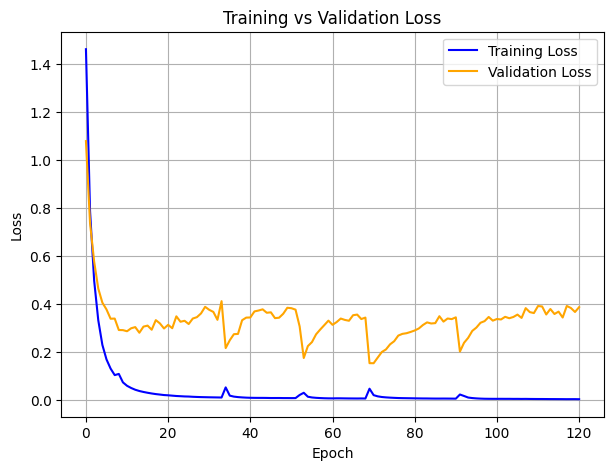

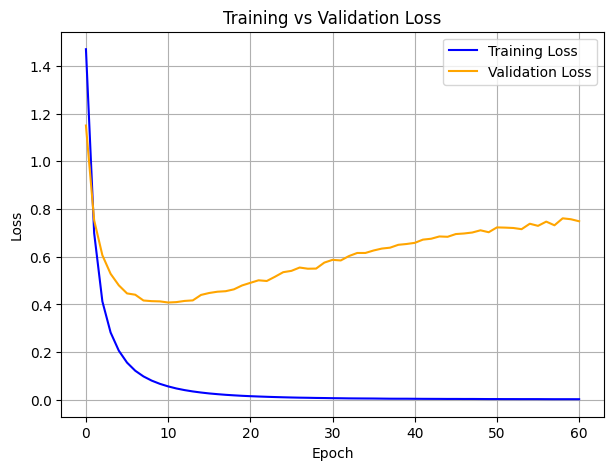

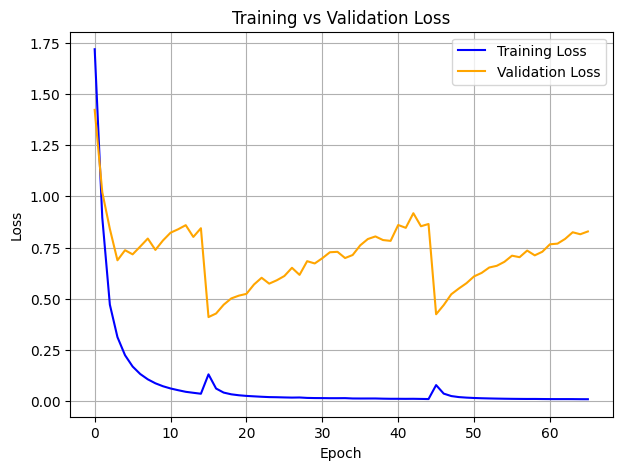

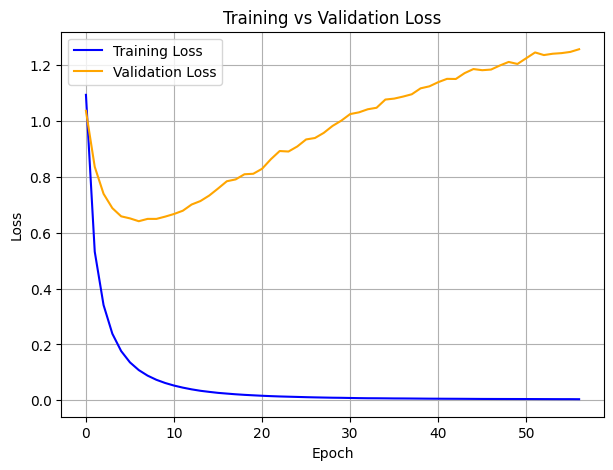

In [ ]:
def execute():
    ## Execution

    from dataArrange import dataRearrange1
    ## Test Learn_EA without annealing
    # training transformations and augmentations

    transforms_training = ComposeDouble([
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
        FunctionWrapperDouble(normalize_01)
    ])

    #追加箇所ver3
    transforms_val =  ComposeDouble([
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
        FunctionWrapperDouble(normalize_01)

    ])

    # random seed
    random_seed = 0

    X = file_names_with_prefix(data_dir, 'N')

    y_file_names = file_names_with_prefix(labeled_dir, 'N')


    # removal = ["N1-2", "N1-4", "N5-6", "N2-9"]
    # X = [item for item in X if item not in removal]
    # y_file_names = [item for item in y_file_names if item not in removal]

    y = [label_group[:2] for label_group in y_file_names]



    X = np.array(X)
    y = np.array(y)


    print(X)
    print(y)



    if CROSS_VAL:
        skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True)
        # each case same division
        #skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
        for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
            # if fold == 1:
            #      continue
            # Split the data into train and test sets
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Split the training data further into train and validation ( 1/3 split)
            X_train_final, X_val, y_train_final, y_val = train_test_split(
                X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
            
            
            input_train = X_train_final
            input_name_val = X_val
            print("Cross validation: " + str(CROSS_VAL))
            print(f"Fold: {fold} out of {N_SPLIT}")
            print("Augmentation: " + str(AUGMENTED))
            if AUGMENTED:
                print("Augmentation amount: " + str(AUGMENTATION))
            print("Training: Total of " + str(len(input_train)) + " cases.")
            print(input_train)

            print("Validation: Total of " + str(len(input_name_val)) + " cases.")
            print(input_name_val)
            
            print("Test: Total of " + str(len(X_test)) + " cases.")  
            print(X_test)
            print()
            
            if AUGMENTED:
                ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
                ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
                repeated_items_train = np.repeat(input_train, AUGMENTATION)
                suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
                input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
                #Custom Arranging for training dataset because of the augmentation order
                input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
                
                
                repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
                suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
                input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
            
            
            #input_dataset,label_dataset = CreateWeightImageNew(input_train, augmentation=AUGMENTED)
            input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
            input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
            
            
            Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0, fold, next_model=True)
            mConv_predict(X_test, fold)
            
            # Force garbage collection 
            gc.collect()

            # Clear CUDA memory
            torch.cuda.empty_cache()

            # Optionally reset max memory tracking
            torch.cuda.reset_peak_memory_stats()
            
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)
        
        X_train_final, X_val, y_train_final, y_val = train_test_split(
                X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
        
        input_train = X_train_final
        input_name_val = X_val
        
        print("Cross validation: " + str(CROSS_VAL))
        print("Augmentation: " + str(AUGMENTED))
        if AUGMENTED:
            print("Augmentation amount: " + str(AUGMENTATION))
        print("Training: Total of " + str(len(input_train)) + " cases.")
        print(input_train)

        print("Validation: Total of " + str(len(input_name_val)) + " cases.")
        print(input_name_val)
            
        print("Test: Total of " + str(len(X_test)) + " cases.")  
        print(X_test)
        print()
        
        if AUGMENTED:
            ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
            ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
            repeated_items_train = np.repeat(input_train, AUGMENTATION)
            suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
            input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
            
            #Custom Arranging for training dataset because of the augmentation order
            input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
                
                
            repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
            suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
            input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
        
        input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
        input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
        
        Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0, next_model=True)
        dice1, dice2 = mConv_predict(X_test)
        

        
        # Force garbage collection
        gc.collect()

        # Clear CUDA memory
        torch.cuda.empty_cache()

        # Optionally reset max memory tracking
        torch.cuda.reset_peak_memory_stats()
        
    return dice1, dice2  

In [ ]:
def objective(trial):
    try:
        # Hyperparameters for Optuna to explore
        
        MINE_EPOCH = trial.suggest_int("mine_epoch", 10, 40)
        MIN_ERROR_THRESHOLD = trial.suggest_int("min_error_threshold", 200, 1000)

        # -----------------
        # TRAINING CALL
        # -----------------
        dice1, dice2 = execute()
        trial.set_user_attr("dice1", dice1)

        log(f"Trial {trial.number} | "
            f"DICE1={dice1:.4f} | "
            f"DICE2={dice2:.4f} | "
            f"params={trial.params}")

        return dice2

    except Exception:
        err = traceback.format_exc()
        log(f"Trial {trial.number} FAILED\n{err}")
        # Fail gracefully and continue study
        return 0.0


In [ ]:
study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=DB_PATH,
    load_if_exists=True,
)

try:
    study.optimize(objective, n_trials=1)
except KeyboardInterrupt:
    log("=== INTERRUPTED BY USER ===")
finally:
    log("=== OPTUNA FINISHED ===")


In [ ]:
# Save best trial information
best = study.best_trial
log(f"Best Trial = {best.number}")
log(f"Best DICE2 = {best.value:.4f}")
log(f"Best DICE1 = {best.user_attrs['dice1']:.4f}")
log(f"Best Params = {best.params}")

with open("best_trial.json", "w") as f:
    json.dump({
        "best_trial": best.number,
        "dice2": best.value,
        "dice1": best.user_attrs['dice1'],
        "params": best.params
    }, f, indent=4)


In [ ]:
df = study.trials_dataframe(attrs=("params", "user_attrs", "value"))
df.to_csv("optuna_results.csv", index=False)


In [ ]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.write_image("optimization_history.png")

fig2 = optuna.visualization.plot_param_importances(study)
fig2.write_image("param_importance.png")

fig3 = optuna.visualization.plot_parallel_coordinate(study)
fig3.write_image("parallel_coordinates.png")

fig4 = optuna.visualization.plot_contour(study)
fig4.write_image("contour_plot.png")
